### Importing the neccessary dependencies


In [1]:
# Import necessary libraries for data manipulation and visualization
import pandas as pd  # For data manipulation and analysis
import numpy as np   # For numerical operations
import matplotlib.pyplot as plt  # For data visualization

# Import PyTorch libraries for building neural networks
import torch  # Core library for tensor computations
import torch.nn as nn  # Module for neural network layers and functions

# Load the dataset into a Pandas DataFrame
data = pd.read_csv('/content/USD_RUB Historical Data.csv')  # Read the CSV file containing GBP to USD historical exchange rate data

# Display the loaded dataset
data  # This will output the contents of the DataFrame

,Date,Price,Open,High,Low,Vol.,Change %
0,03/29/2024,92.480,92.500,92.6775,91.9833,NaN,-0.02%
1,03/28/2024,92.500,92.305,92.5785,91.9050,NaN,0.21%
2,03/27/2024,92.305,92.700,92.8375,91.7770,NaN,-0.43%
3,03/26/2024,92.700,92.580,92.8718,92.3600,NaN,0.13%
4,03/25/2024,92.580,92.795,93.0475,92.5157,NaN,-0.23%
...,...,...,...,...,...,...,...
3587,04/05/2010,29.200,29.240,29.2480,29.1400,NaN,-0.15%
3588,04/02/2010,29.245,29.260,29.2750,29.1740,NaN,-0.03%
3589,04/01/2010,29.255,29.439,29.4690,29.2400,NaN,-0.61%
3590,03/31/2010,29.434,29.507,29.5530,29.3910,NaN,-0.26%


In [2]:
# Rename the 'Price' column to 'Close' for better clarity and consistency with financial terminology
data.rename(columns={'Price': 'Close'}, inplace=True)  # Update the DataFrame in place to reflect the new column name

In [3]:
data.columns # output the fields

Index(['Date', 'Close', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

In [4]:
data['Vol.'].values

array([nan, nan, nan, ..., nan, nan, nan])

In [5]:
# checking for missing values
data.isnull().sum()

,0
Date,0
Close,0
Open,0
High,0
Low,0
Vol.,3592
Change %,0


In [6]:
data['Vol.'].dropna() # dropping the missing values

,Vol.


In [7]:
data.head()

,Date,Close,Open,High,Low,Vol.,Change %
0,03/29/2024,92.480,92.500,92.6775,91.9833,NaN,-0.02%
1,03/28/2024,92.500,92.305,92.5785,91.9050,NaN,0.21%
2,03/27/2024,92.305,92.700,92.8375,91.7770,NaN,-0.43%
3,03/26/2024,92.700,92.580,92.8718,92.3600,NaN,0.13%
4,03/25/2024,92.580,92.795,93.0475,92.5157,NaN,-0.23%


In [8]:
## getting the date and close entries

data = data[['Date', 'Close']]
data

,Date,Close
0,03/29/2024,92.480
1,03/28/2024,92.500
2,03/27/2024,92.305
3,03/26/2024,92.700
4,03/25/2024,92.580
...,...,...
3587,04/05/2010,29.200
3588,04/02/2010,29.245
3589,04/01/2010,29.255
3590,03/31/2010,29.434


In [9]:
# checking the processor in use
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

<ipython-input-10-1db96b14793e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


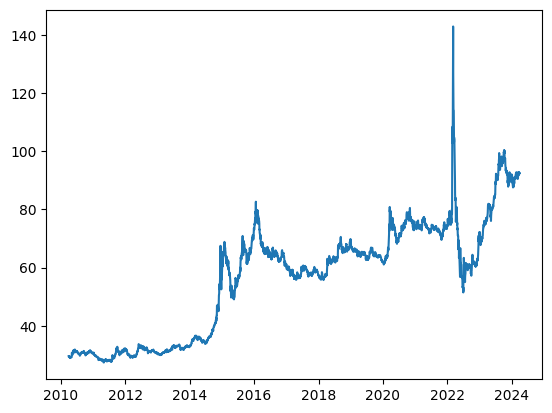

In [10]:
# converting the date column from strings to datatime
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [11]:
# Preparing the dataset for building an LSTM RNN model
from copy import deepcopy as dc  # Importing deepcopy to avoid modifying the original DataFrame

def prepare_dataframe_for_lstm(df, n_steps):
    # Create a deep copy of the DataFrame to avoid altering the original data
    df = dc(df)

    # Set 'Date' column as the index for time series analysis
    df.set_index('Date', inplace=True)

    # Create lagged features for 'Close' prices based on the specified number of steps (lookback period)
    for i in range(1, n_steps + 1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)  # Create a new column for each lagged value

    # Remove rows with NaN values that result from the shifting operation
    df.dropna(inplace=True)

    return df  # Return the modified DataFrame with lagged features

# Define the number of previous time steps to use as input for the LSTM
lookback = 7
# Prepare the DataFrame by generating lagged features based on the specified lookback
shifted_df = prepare_dataframe_for_lstm(data, lookback)
# Display the transformed DataFrame
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2024-03-20,92.2500,92.0625,92.7950,92.5800,92.7000,92.3050,92.500,92.480
2024-03-19,92.6475,92.2500,92.0625,92.7950,92.5800,92.7000,92.305,92.500
2024-03-18,91.9175,92.6475,92.2500,92.0625,92.7950,92.5800,92.700,92.305
2024-03-15,92.9025,91.9175,92.6475,92.2500,92.0625,92.7950,92.580,92.700
2024-03-14,91.7200,92.9025,91.9175,92.6475,92.2500,92.0625,92.795,92.580
...,...,...,...,...,...,...,...,...
2010-04-05,29.2000,29.3250,29.3220,29.4170,29.1350,29.0160,29.044,28.947
2010-04-02,29.2450,29.2000,29.3250,29.3220,29.4170,29.1350,29.016,29.044
2010-04-01,29.2550,29.2450,29.2000,29.3250,29.3220,29.4170,29.135,29.016


In [12]:
# converting to numpy array
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[92.25  , 92.0625, 92.795 , ..., 92.305 , 92.5   , 92.48  ],
       [92.6475, 92.25  , 92.0625, ..., 92.7   , 92.305 , 92.5   ],
       [91.9175, 92.6475, 92.25  , ..., 92.58  , 92.7   , 92.305 ],
       ...,
       [29.255 , 29.245 , 29.2   , ..., 29.417 , 29.135 , 29.016 ],
       [29.434 , 29.255 , 29.245 , ..., 29.322 , 29.417 , 29.135 ],
       [29.51  , 29.434 , 29.255 , ..., 29.325 , 29.322 , 29.417 ]])

In [13]:
# checking the shape
shifted_df_as_np.shape

(3585, 8)

In [14]:
# scaling transformation
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[ 0.12241642,  0.11917412,  0.13184072, ...,  0.1233675 ,
         0.1267395 ,  0.12639365],
       [ 0.12929011,  0.12241642,  0.11917412, ...,  0.13019795,
         0.1233675 ,  0.1267395 ],
       [ 0.11666674,  0.12929011,  0.12241642, ...,  0.12812288,
         0.13019795,  0.1233675 ],
       ...,
       [-0.96691121, -0.96708413, -0.96786228, ..., -0.96410986,
        -0.96898628, -0.97104407],
       [-0.96381589, -0.96691121, -0.96708413, ..., -0.96575263,
        -0.96410986, -0.96898628],
       [-0.96250168, -0.96381589, -0.96691121, ..., -0.96570075,
        -0.96575263, -0.96410986]])

In [15]:
# feature selection
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((3585, 7), (3585,))

In [16]:
# Flip the data along the X-axis (horizontal flip) to reverse the order of the features
X = dc(np.flip(X, axis=1))  # Create a deep copy of the flipped array to preserve the original data
# Display the flipped data
X

array([[ 0.12639365,  0.1267395 ,  0.1233675 , ...,  0.12812288,
         0.13184072,  0.11917412],
       [ 0.1267395 ,  0.1233675 ,  0.13019795, ...,  0.13184072,
         0.11917412,  0.12241642],
       [ 0.1233675 ,  0.13019795,  0.12812288, ...,  0.11917412,
         0.12241642,  0.12929011],
       ...,
       [-0.97104407, -0.96898628, -0.96410986, ..., -0.96570075,
        -0.96786228, -0.96708413],
       [-0.96898628, -0.96410986, -0.96575263, ..., -0.96786228,
        -0.96708413, -0.96691121],
       [-0.96410986, -0.96575263, -0.96570075, ..., -0.96708413,
        -0.96691121, -0.96381589]])

In [17]:
# Calculate the index to split the dataset into training and testing sets
# Using 95% of the data for training and the remaining 5% for testing
split_index = int(len(X) * 0.95)

# Display the calculated split index
split_index

3405

In [18]:
## Splitting the data into training and testing sets

# Create the training set using the first 95% of the data
X_train = X[:split_index]  # Features for training
y_train = y[:split_index]  # Target values for training

# Create the testing set using the remaining 5% of the data
X_test = X[split_index:]   # Features for testing
y_test = y[split_index:]   # Target values for testing

# Display the shapes of the training and testing sets for verification
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3405, 7), (180, 7), (3405,), (180,))

In [19]:
# Reshape the training and testing feature sets to match the input shape required by the LSTM model
# The shape will be (samples, time steps, features), where 'samples' is inferred automatically (-1),
# 'lookback' is the number of time steps, and '1' represents the single feature (Close price)

X_train = X_train.reshape((-1, lookback, 1))  # Reshape training features
X_test = X_test.reshape((-1, lookback, 1))    # Reshape testing features

# Reshape the target values to ensure they have the shape (samples, 1)
y_train = y_train.reshape((-1, 1))  # Reshape training targets
y_test = y_test.reshape((-1, 1))    # Reshape testing targets

# Display the shapes of the reshaped datasets for verification
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3405, 7, 1), (180, 7, 1), (3405, 1), (180, 1))

In [20]:
# Convert the training and testing datasets from NumPy arrays to PyTorch tensors
# This is necessary for compatibility with PyTorch models

X_train = torch.tensor(X_train).float()  # Convert training features to a float tensor
y_train = torch.tensor(y_train).float()  # Convert training targets to a float tensor
X_test = torch.tensor(X_test).float()    # Convert testing features to a float tensor
y_test = torch.tensor(y_test).float()    # Convert testing targets to a float tensor

# Display the shapes of the tensors to verify the conversion
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3405, 7, 1]),
 torch.Size([180, 7, 1]),
 torch.Size([3405, 1]),
 torch.Size([180, 1]))

In [21]:
from torch.utils.data import Dataset  # Importing the Dataset class from PyTorch for custom dataset creation

# Define a custom dataset class for time series data
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        # Initialize the dataset with features (X) and targets (y)
        self.X = X  # Store the feature tensor
        self.y = y  # Store the target tensor

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.X)  # Number of samples is based on the length of X

    def __getitem__(self, i):
        # Retrieve a sample from the dataset
        return self.X[i], self.y[i]  # Return the feature and target at index i

# Create instances of the TimeSeriesDataset for training and testing data
train_dataset = TimeSeriesDataset(X_train, y_train)  # Training dataset
test_dataset = TimeSeriesDataset(X_test, y_test)      # Testing dataset

In [22]:
train_dataset

In [23]:
from torch.utils.data import DataLoader  # Importing the DataLoader class for loading data in batches

# Define the batch size for training and testing
batch_size = 16  # Number of samples per batch

# Create a DataLoader for the training dataset
# It shuffles the data at every epoch for better generalization
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create a DataLoader for the testing dataset
# No shuffling is performed for the testing data to maintain the order of samples
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [24]:
# Iterate over the training DataLoader to retrieve batches of data
for _, batch in enumerate(train_loader):
    # Unpack the batch into features (x_batch) and targets (y_batch)
    # Move the tensors to the specified device (CPU or GPU)
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    # Print the shapes of the feature and target batches for verification
    print(x_batch.shape, y_batch.shape)

    # Break after the first batch to avoid printing shapes for all batches
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [25]:
import torch.nn as nn  # Importing the neural network module from PyTorch

# Define an LSTM model class
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()  # Initialize the parent class
        self.hidden_size = hidden_size  # Set the hidden size
        self.num_stacked_layers = num_stacked_layers  # Set the number of stacked LSTM layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)

        # Define a fully connected layer for output
        self.fc = nn.Linear(hidden_size, 1)  # Output a single value

    def forward(self, x):
        # Define the forward pass
        batch_size = x.size(0)  # Get the batch size from input
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        # Pass the input through the LSTM layer
        out, _ = self.lstm(x, (h0, c0))  # Get the output and hidden states

        # Pass the output from the last time step through the fully connected layer
        out = self.fc(out[:, -1, :])  # Only take the last time step's output
        return out  # Return the final output

# Create an instance of the LSTM model with specified parameters
model = LSTM(1, 4, 1)  # Input size of 1, hidden size of 4, and 1 stacked layer
model.to(device)  # Move the model to the specified device (CPU or GPU)

# Display the model architecture
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [26]:
def train_one_epoch():
    # Set the model to training mode
    model.train(True)
    print(f'Epoch: {epoch + 1}')  # Print the current epoch number
    running_loss = 0.0  # Initialize cumulative loss for the epoch

    # Iterate over the training DataLoader
    for batch_index, batch in enumerate(train_loader):
        # Move the batch data to the specified device (CPU or GPU)
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Forward pass: Get model predictions
        output = model(x_batch)

        # Calculate the loss between predictions and true values
        loss = loss_function(output, y_batch)
        running_loss += loss.item()  # Accumulate the loss

        # Backward pass: Compute gradients
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Backpropagate to compute current gradients
        optimizer.step()       # Update model parameters

        # Print the average loss every 100 batches
        if batch_index % 100 == 99:  # Every 100 batches
            avg_loss_across_batches = running_loss / 100  # Calculate average loss
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index + 1, avg_loss_across_batches))
            running_loss = 0.0  # Reset running loss for the next 100 batches

    print()  # Print a newline for better readability at the end of the epoch

In [27]:
def validate_one_epoch():
    # Set the model to evaluation mode (disables dropout, batch normalization, etc.)
    model.train(False)
    running_loss = 0.0  # Initialize cumulative loss for the validation epoch

    # Iterate over the testing DataLoader
    for batch_index, batch in enumerate(test_loader):
        # Move the batch data to the specified device (CPU or GPU)
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Disable gradient calculation for validation (saves memory and computation)
        with torch.no_grad():
            # Forward pass: Get model predictions
            output = model(x_batch)
            # Calculate the loss between predictions and true values
            loss = loss_function(output, y_batch)
            running_loss += loss.item()  # Accumulate the loss

    # Calculate the average loss across all batches in the validation set
    avg_loss_across_batches = running_loss / len(test_loader)

    # Print the average validation loss for this epoch
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')  # Separator for readability
    print()  # Print a newline for better readability at the end of validation

In [28]:
# Set the learning rate for the optimizer
learning_rate = 0.001  # A common choice for Adam optimizer

# Define the number of epochs for training
num_epochs = 10  # Total number of epochs to train the model

# Define the loss function to be used
loss_function = nn.MSELoss()  # Mean Squared Error Loss for regression tasks

# Initialize the Adam optimizer with the model parameters and specified learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop for the specified number of epochs
for epoch in range(num_epochs):
    # Train the model for one epoch
    train_one_epoch()
    # Validate the model after training for the epoch
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.277
Batch 200, Loss: 0.105

Val Loss: 0.107
***************************************************

Epoch: 2
Batch 100, Loss: 0.029
Batch 200, Loss: 0.002

Val Loss: 0.000
***************************************************

Epoch: 3
Batch 100, Loss: 0.002
Batch 200, Loss: 0.002

Val Loss: 0.000
***************************************************

Epoch: 4
Batch 100, Loss: 0.002
Batch 200, Loss: 0.002

Val Loss: 0.000
***************************************************

Epoch: 5
Batch 100, Loss: 0.002
Batch 200, Loss: 0.001

Val Loss: 0.000
***************************************************

Epoch: 6
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001

Val Loss: 0.000
***************************************************

Epoch: 7
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001

Val Loss: 0.000
***************************************************

Epoch: 8
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001

Val Loss: 0.000
***************************************************



In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Importing metrics for evaluation

# Calculate the Mean Absolute Error (MAE) and Mean Squared Error (MSE)
# Move the test features to the specified device, get predictions, and detach from the computation graph
y_pred = model(X_test.to(device)).detach().cpu().numpy()  # Obtain predictions as a NumPy array

# Compute the Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)  # Compare true values to predictions

# Compute the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)  # Compare true values to predictions

# Print the evaluation metrics
print(f'MAE: {mae:.4f}, MSE: {mse:.4f}')  # Display MAE and MSE with 4 decimal precision

MAE: 0.0081, MSE: 0.0001


In [30]:
from sklearn.metrics import r2_score  # Importing the R² score metric for evaluation

# Calculate the R² score, which indicates the proportion of variance explained by the model
r2 = r2_score(y_test, y_pred=model(X_test.to(device)).detach().cpu().numpy())  # Compare true values to predictions

# Print the R² score
print(f'R2 Score: {r2:.4f}')  # Display the R² score with 4 decimal precision

R2 Score: 0.3461


In [31]:

y_test = y_test.detach().cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test

# Get predictions from the model
y_pred = model(X_test.to(device)).detach().cpu().numpy()

# Ensure both y_test and y_pred are 1D arrays
if y_test.ndim > 1:
    y_test = y_test.flatten()
if y_pred.ndim > 1:
    y_pred = y_pred.flatten()

# Calculate percentage error
percentage_error = np.abs((y_test - y_pred) / y_test) * 100

# Print percentage error for each prediction
for i, error in enumerate(percentage_error):
    print(f'Percentage Error for sample {i}: {error:.2f}%')

Percentage Error for sample 0: 0.15%
Percentage Error for sample 1: 0.24%
Percentage Error for sample 2: 0.38%
Percentage Error for sample 3: 0.17%
Percentage Error for sample 4: 0.04%
Percentage Error for sample 5: 0.43%
Percentage Error for sample 6: 0.39%
Percentage Error for sample 7: 0.85%
Percentage Error for sample 8: 0.59%
Percentage Error for sample 9: 0.40%
Percentage Error for sample 10: 0.81%
Percentage Error for sample 11: 0.81%
Percentage Error for sample 12: 0.79%
Percentage Error for sample 13: 0.31%
Percentage Error for sample 14: 0.61%
Percentage Error for sample 15: 0.90%
Percentage Error for sample 16: 1.18%
Percentage Error for sample 17: 1.35%
Percentage Error for sample 18: 0.98%
Percentage Error for sample 19: 1.05%
Percentage Error for sample 20: 0.62%
Percentage Error for sample 21: 1.17%
Percentage Error for sample 22: 1.12%
Percentage Error for sample 23: 0.39%
Percentage Error for sample 24: 0.55%
Percentage Error for sample 25: 0.49%
Percentage Error for s

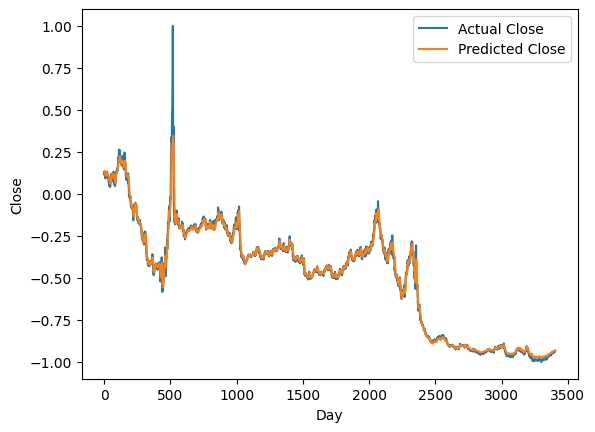

In [32]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [33]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([92.86929603, 92.82896826, 92.88155232, ..., 31.16913903,
       31.19747248, 31.24907935])

In [34]:
# Create an array to hold the true values and prepare for inverse scaling
dummies = np.zeros((X_train.shape[0], lookback + 1))  # Initialize an array with zeros

# Fill the first column with the flattened true values from y_train
dummies[:, 0] = y_train.flatten()  # Flatten y_train to a 1D array and store in the first column

# Inverse transform the scaled data to obtain the original scale values
dummies = scaler.inverse_transform(dummies)  # Apply inverse scaling to recover original values

# Create a deep copy of the first column (original true values)
new_y_train = dc(dummies[:, 0])  # Store the recovered true values in new_y_train

# Display the new_y_train values
new_y_train

array([92.24999986, 92.64749974, 91.91750017, ..., 30.9390004 ,
       31.04900106, 31.13600061])

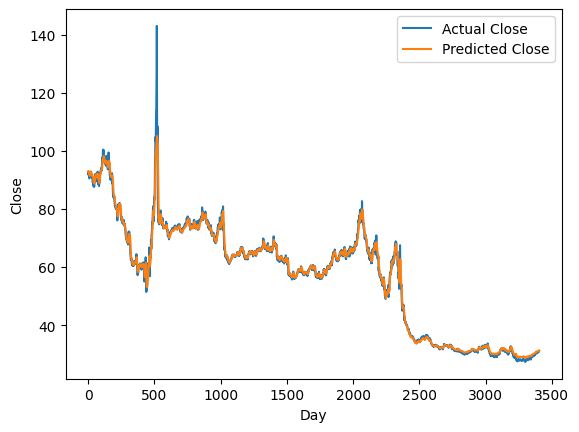

In [35]:
# Plot the actual and predicted closing prices for comparison
plt.plot(new_y_train, label='Actual Close')  # Plot the actual closing prices from the training set
plt.plot(train_predictions, label='Predicted Close')  # Plot the predicted closing prices

# Label the x-axis and y-axis
plt.xlabel('Day')  # X-axis represents the days
plt.ylabel('Close')  # Y-axis represents the closing prices

# Add a legend to differentiate between actual and predicted values
plt.legend()

# Display the plot
plt.show()  # Render the plot to the screen

In [36]:
# Generate predictions for the test set using the trained model
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()  # Get predictions and flatten to 1D array

# Create an array to hold the predictions and prepare for inverse scaling
dummies = np.zeros((X_test.shape[0], lookback + 1))  # Initialize an array with zeros

# Fill the first column with the flattened test predictions
dummies[:, 0] = test_predictions  # Store the test predictions in the first column

# Inverse transform the scaled data to obtain the original scale values
dummies = scaler.inverse_transform(dummies)  # Apply inverse scaling to recover original values

# Create a deep copy of the first column (original test predictions)
test_predictions = dc(dummies[:, 0])  # Store the recovered test predictions

# Display the test_predictions values
test_predictions

array([31.30520509, 31.36606686, 31.41883188, 31.45499667, 31.50988498,
       31.58675067, 31.60071747, 31.61927209, 31.57983275, 31.57548622,
       31.59050778, 31.54822476, 31.50478702, 31.47060075, 31.49415336,
       31.48411601, 31.43753472, 31.35731865, 31.26674467, 31.22396185,
       31.16931827, 31.16066657, 31.08693755, 31.03262832, 31.07439431,
       31.09523767, 31.12028623, 31.13913384, 31.11330628, 31.11533994,
       31.06362967, 30.98144543, 30.93266156, 30.94109956, 30.96676511,
       30.98920438, 30.94517378, 30.90986382, 30.82939268, 30.78263215,
       30.73235234, 30.64734509, 30.57251651, 30.50948665, 30.47977444,
       30.50181731, 30.60979809, 30.68602266, 30.77702405, 30.81899686,
       30.86555058, 30.9143241 , 30.99189985, 31.09246981, 31.15981519,
       31.22644706, 31.28583356, 31.31192308, 31.40385169, 31.37919607,
       31.28460302, 31.22879784, 31.2296113 , 31.21454494, 31.20036098,
       31.18949637, 31.14473159, 31.12323332, 31.11984848, 31.11

In [37]:
# Create an array to hold the true values for the test set and prepare for inverse scaling
dummies = np.zeros((X_test.shape[0], lookback + 1))  # Initialize an array with zeros

# Fill the first column with the flattened true values from y_test
dummies[:, 0] = y_test.flatten()  # Flatten y_test to a 1D array and store in the first column

# Inverse transform the scaled data to recover the original scale values
dummies = scaler.inverse_transform(dummies)  # Apply inverse scaling to recover original values

# Create a deep copy of the first column (original true test values)
new_y_test = dc(dummies[:, 0])  # Store the recovered true values in new_y_test

# Display the new_y_test values
new_y_test

array([31.22449956, 31.23700144, 31.21350053, 31.36399872, 31.5311006 ,
       31.35599849, 31.38829931, 31.16000132, 31.26400094, 31.35800113,
       31.15300068, 31.1119999 , 31.07899936, 31.30500172, 31.16599891,
       30.99800085, 30.794     , 30.62000089, 30.73200075, 30.65099879,
       30.83400118, 30.51900007, 30.47600009, 30.8199999 , 30.77400113,
       30.82800014, 30.81399886, 30.6460008 , 30.68499893, 30.44800099,
       30.29300115, 30.34700016, 30.57600132, 30.68100054, 30.6739999 ,
       30.38700134, 30.31499922, 30.04600033, 30.11699941, 30.10300158,
       29.91099936, 29.84900011, 29.77599839, 29.84700092, 30.02700106,
       30.47300129, 30.46400146, 30.56900068, 30.42200108, 30.45800042,
       30.53300134, 30.75800066, 31.02599995, 30.99299941, 31.05900049,
       31.06800033, 30.98200038, 31.31400156, 30.94600104, 30.61699865,
       30.66599967, 30.88600099, 30.84300101, 30.8229987 , 30.85900148,
       30.63199952, 30.62700153, 30.70099941, 30.71500068, 30.78

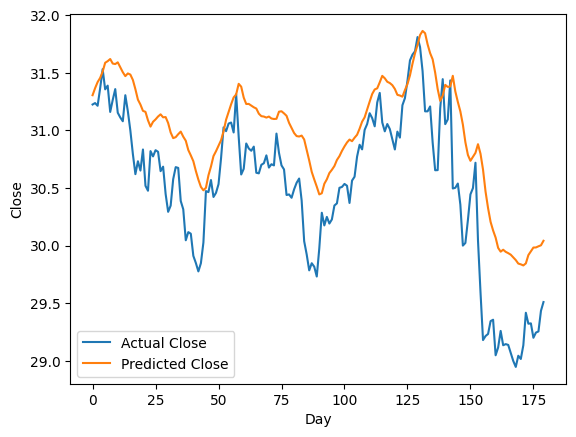

In [38]:
# Plot the actual and predicted closing prices for the test set
plt.plot(new_y_test, label='Actual Close')  # Plot the actual closing prices from the test set
plt.plot(test_predictions, label='Predicted Close')  # Plot the predicted closing prices

# Label the x-axis and y-axis
plt.xlabel('Day')  # X-axis represents the days in the test set
plt.ylabel('Close')  # Y-axis represents the closing prices

# Add a legend to differentiate between actual and predicted values
plt.legend()

# Display the plot
plt.show()  # Render the plot to the screen
